In [1]:
import pandas as pd
import numpy as np
import librosa

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

df = pd.read_csv('Path_DF.csv')
valve_train = df[(df.Dataset == 'train') & (df.Machine_Type == 'valve')]

valve_train.head()

,Path,Machine_Type,Dataset,Status,Machine_ID,Sample_ID,nb_echantillon,freq_echantillonnage,audio
7388,Data/valve/train/normal_id_04_00000895.wav,valve,train,normal,4,895,160000,16000,[-0.0067749 -0.00421143 -0.00149536 ... -0.01...
7389,Data/valve/train/normal_id_00_00000692.wav,valve,train,normal,0,692,160000,16000,[-1.6845703e-02 -8.6669922e-03 -9.1552734e-05 ...
7390,Data/valve/train/normal_id_06_00000093.wav,valve,train,normal,6,93,160000,16000,[-0.00506592 -0.00900269 -0.00445557 ... 0.00...
7391,Data/valve/train/normal_id_00_00000686.wav,valve,train,normal,0,686,160000,16000,[ 0.00064087 0.00460815 0.00891113 ... 0.00...
7392,Data/valve/train/normal_id_06_00000087.wav,valve,train,normal,6,87,160000,16000,[-0.01055908 -0.01242065 -0.01312256 ... -0.02...


In [2]:
import sys

def file_to_vector_array(filepath, sr=16000, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1.0):
    """
    convert filepath to a vector array.
    filepath : chemin du fichier
    return : numpy.array( numpy.array(float))
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    y, _ = load_audio(filepath)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)

    # convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    vector_array = log_mel_spectrogram.T

    return vector_array

In [3]:
audio_valve = []
for i in range(len(valve_train)): 
    audio_valve.append(file_to_vector_array(valve_train.iloc[i,0])[0])

In [4]:
from sklearn.preprocessing import StandardScaler

scaler_valve = StandardScaler().fit(audio_valve)

In [5]:
def file_to_vector_array_norm(filepath, scaler, sr=16000, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1.0):
    """
    convert filepath to a vector array normalisé.
    file_name : chemin du fichier
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    vector_array = file_to_vector_array(filepath, sr, n_mels, frames, n_fft, hop_length, power)
    vector_array = scaler.transform(vector_array)
    return vector_array

In [6]:
file_to_vector_array_norm(valve_train.iloc[0,0], scaler = scaler_valve).shape

(313, 128)

In [7]:
# préparer le jeu de données

def file_to_vector_ConvAE(filepath, scaler, sr=16000, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1.0):
    vector_array = file_to_vector_array_norm(filepath, scaler, sr, n_mels, frames, n_fft, hop_length, power)
    length, _ = vector_array.shape
    dim = 32
    step = 3
    idex = np.arange(length-dim+step, step=step)
    for idx in range(len(idex)):
        start = min(idex[idx], length - dim)
        vector = vector_array[start:start+dim,:]
        vector = vector.reshape((1, vector.shape[0], vector.shape[1]))
        if idx==0:
            batch = vector
        else:
            batch = np.concatenate((batch, vector))
                        
    # add channels dimension
    data = batch.reshape((batch.shape[0], batch.shape[1], batch.shape[2], 1))
    return data


In [8]:
file_to_vector_ConvAE(valve_train.iloc[10,0], scaler_valve).shape

(95, 32, 128, 1)

In [9]:
def dataset_conv(set_files, scaler, sr=16000, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1.0):
    """
    renvoie une dataset sur laquelle entrainer/évaluer le modèle Conv_AE
    set_files est un DataFrame et sa première colonne contient les chemins
    """
    # iterate file_to_vector_ConvAE()
    for k in range(len(set_files)):
        vector = file_to_vector_ConvAE(set_files.iloc[k,0], scaler, sr, n_mels, frames, n_fft, hop_length, power)
        if k == 0:
            X = np.empty((len(set_files)*vector.shape[0], vector.shape[1], vector.shape[2], vector.shape[3]))
            i = 0
            for l in vector:
                X[i,] = l
                i += 1
        else :
            i = k*vector.shape[0]
            for l in vector:
                X[i,] = l
                i += 1 
    return X


In [10]:
from time import time
t0 = time()

valve_train_feat = dataset_conv(valve_train, scaler_valve)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 153.99 secondes


In [11]:
valve_train_feat.shape

(312645, 32, 128, 1)

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, BatchNormalization, ReLU, Reshape

def model_convAE(input_shape = (32, 128, 1)):
    model_conv = Sequential()

    # Première couche Encoder
    model_conv.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,2), padding = 'same', input_shape = input_shape))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Seconde couche Encoder
    model_conv.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = (1,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Troisième couche Encoder
    model_conv.add(Conv2D(filters = 128, kernel_size = (5, 5), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Quatrième couche Encoder
    model_conv.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Cinquième couche Encoder
    model_conv.add(Conv2D(filters = 512, kernel_size = (3, 3), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Couche goulot
    model_conv.add(Conv2D(filters = 40, kernel_size = (4, 4), strides = (1,1), padding = 'valid'))
    model_conv.add(Flatten())

    # Première couche Decoder
    model_conv.add(Dense(4*4*512))
    model_conv.add(Reshape((4,4,512)))

    # Seconde couche Decoder
    model_conv.add(Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Troisième couche Decoder
    model_conv.add(Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Quatrième couche Decoder
    model_conv.add(Conv2DTranspose(filters = 64, kernel_size = (5, 5), strides = (2,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Cinquième couche Decoder
    model_conv.add(Conv2DTranspose(filters = 32, kernel_size = (5, 5), strides = (1,2), padding = 'same'))
    model_conv.add(BatchNormalization())
    model_conv.add(ReLU())

    # Couche de reconstruction 
    model_conv.add(Conv2DTranspose(filters = 1, kernel_size = (5, 5), strides = (1,2), padding = 'same'))
    
    return model_conv

model_conv_valve = model_convAE()

# On compile 

model_conv_valve.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [15]:
from tensorflow.keras import callbacks

# Callback pour arrêter l'entrainement et récupérer le meilleur modèle si la métrique ne diminue plus pendant 10 epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', min_delta=0.0001)

import os
cwd = os.getcwd()
filepath = cwd

# Callback pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(filepath = filepath + '/Conv_valve.hdf5', monitor = 'val_loss', save_best_only = True, 
                                       save_weights_only = False, mode = 'min', save_freq = 'epoch')

# Pour modèle Conv AE
model_conv_valve.fit(valve_train_feat, valve_train_feat, batch_size = 64, epochs = 3, callbacks=[checkpoint, early_stopping], 
               validation_split = 0.3)


Epoch 1/3
3420/3420 [==============================] - 3977s 1s/step - loss: 0.2653 - val_loss: 0.2516
Epoch 2/3
3420/3420 [==============================] - 4242s 1s/step - loss: 0.2400 - val_loss: 0.2411
Epoch 3/3
3420/3420 [==============================] - 4229s 1s/step - loss: 0.2346 - val_loss: 0.2376


## Evaluation du modèle sur chaque machine_id

### Machine_id = 0

In [16]:
valve_test_0 = df[(df.Dataset == 'test') & (df.Machine_Type == 'valve') & (df.Machine_ID == 0)]

valve_test_feat_0 = dataset_conv(valve_test_0, scaler_valve)


In [19]:
pred_valve_test_0 = model_conv_valve.predict(valve_test_feat_0)

In [17]:
def errors(X_true, X_pred, length, nb_extract = 95): 
    """
    calcule les erreurs entre le jeu de départ et les prédictions du modèle
    """
    vect_error = np.mean(np.square(X_true - X_pred), axis=-1)
    errors = np.zeros(length)
    for k in range(length):
        errors[k] = np.mean(vect_error[k*nb_extract : (k+1)*nb_extract])
    return errors


In [131]:
error_valve_test_0 = errors(valve_test_feat_0, pred_valve_test_0, len(valve_test_0))

y_true = valve_test_0['Status'].replace(['normal', 'anomaly'], [0,1])

y_true.value_counts()

1    119
0    100
Name: Status, dtype: int64

In [85]:
print('Moyenne des erreurs :', np.mean(error_valve_test_0))
print('Ecart-type des erreurs :', np.std(error_valve_test_0))

Moyenne des erreurs : 0.23615679365243916
Ecart-type des erreurs : 0.018052303447486137


In [86]:
seuil = .227 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_valve_test_0[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,58,42
1,18,101


In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.58      0.66       100
           1       0.71      0.85      0.77       119

    accuracy                           0.73       219
   macro avg       0.73      0.71      0.72       219
weighted avg       0.73      0.73      0.72       219



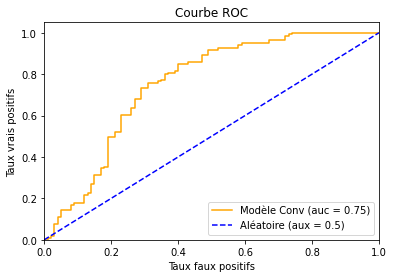

In [132]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true, error_valve_test_0, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle Conv (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [133]:
auc = roc_auc_score(y_true, error_valve_test_0)
p_auc = roc_auc_score(y_true, error_valve_test_0, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7510924369747899
pAUC : 0.5254312251216275


### Machine_id = 2

In [41]:
valve_test_2 = df[(df.Dataset == 'test') & (df.Machine_Type == 'valve') & (df.Machine_ID == 2)]

valve_test_feat_2 = dataset_conv(valve_test_2, scaler_valve)

pred_valve_test_2 = model_conv_valve.predict(valve_test_feat_2)

In [134]:
error_valve_test_2 = errors(valve_test_feat_2, pred_valve_test_2, len(valve_test_2))

print('Moyenne des erreurs :', np.mean(error_valve_test_2))
print('Ecart-type des erreurs :', np.std(error_valve_test_2))

y_true = valve_test_2['Status'].replace(['normal', 'anomaly'], [0,1])

Moyenne des erreurs : 0.24314437472138223
Ecart-type des erreurs : 0.01883153034697012


In [90]:
seuil = .23585 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_valve_test_2[:] > seuil, 1, 0)

print(classification_report(y_true, y_pred))
pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       100
           1       0.79      0.87      0.83       120

    accuracy                           0.80       220
   macro avg       0.81      0.80      0.80       220
weighted avg       0.81      0.80      0.80       220



Classe prédite,0,1
Classe réelle,,
0,73,27
1,16,104


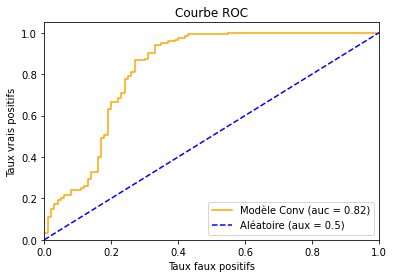

In [135]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true, error_valve_test_2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle Conv (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [136]:
auc = roc_auc_score(y_true, error_valve_test_2)
p_auc = roc_auc_score(y_true, error_valve_test_2, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.82375
pAUC : 0.5671052631578948


### Machine_id = 4

In [77]:
valve_test_4 = df[(df.Dataset == 'test') & (df.Machine_Type == 'valve') & (df.Machine_ID == 4)]

valve_test_feat_4 = dataset_conv(valve_test_4, scaler_valve)

pred_valve_test_4 = model_conv_valve.predict(valve_test_feat_4)

In [137]:
error_valve_test_4 = errors(valve_test_feat_4, pred_valve_test_4, len(valve_test_4))

print('Moyenne des erreurs :', np.mean(error_valve_test_4))
print('Ecart-type des erreurs :', np.std(error_valve_test_4))

y_true = valve_test_4['Status'].replace(['normal', 'anomaly'], [0,1])

Moyenne des erreurs : 0.2471831696816168
Ecart-type des erreurs : 0.024267587993810426


In [94]:
seuil = .2358 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_valve_test_4[:] > seuil, 1, 0)

print(classification_report(y_true, y_pred))
pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       100
           1       0.76      0.90      0.82       120

    accuracy                           0.79       220
   macro avg       0.80      0.78      0.78       220
weighted avg       0.80      0.79      0.78       220



Classe prédite,0,1
Classe réelle,,
0,65,35
1,12,108


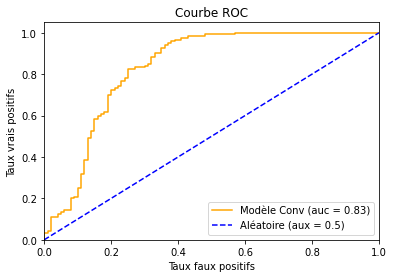

In [138]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, seuils = roc_curve(y_true, error_valve_test_4, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle Conv (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [139]:
auc = roc_auc_score(y_true, error_valve_test_4)
p_auc = roc_auc_score(y_true, error_valve_test_4, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.8309166666666666
pAUC : 0.5390350877192982


### Machine_id = 6

In [98]:
valve_test_6 = df[(df.Dataset == 'test') & (df.Machine_Type == 'valve') & (df.Machine_ID == 6)]

valve_test_feat_6 = dataset_conv(valve_test_6, scaler_valve)

pred_valve_test_6 = model_conv_valve.predict(valve_test_feat_6)

In [141]:
error_valve_test_6 = errors(valve_test_feat_6, pred_valve_test_6, len(valve_test_6))

print('Moyenne des erreurs :', np.mean(error_valve_test_6))
print('Ecart-type des erreurs :', np.std(error_valve_test_6))

y_true = valve_test_6['Status'].replace(['normal', 'anomaly'], [0,1])

Moyenne des erreurs : 0.24380668202067368
Ecart-type des erreurs : 0.019829395223353797


In [119]:
seuil = .233 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_valve_test_6[:] > seuil, 1, 0)

print(classification_report(y_true, y_pred))
pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.73      0.58      0.65       100
           1       0.70      0.82      0.76       120

    accuracy                           0.71       220
   macro avg       0.72      0.70      0.70       220
weighted avg       0.72      0.71      0.71       220



Classe prédite,0,1
Classe réelle,,
0,58,42
1,21,99


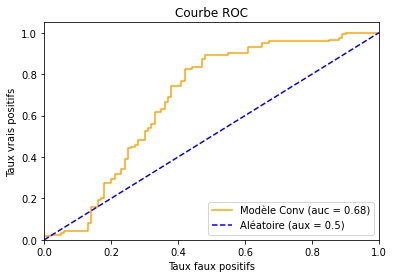

In [142]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, seuils = roc_curve(y_true, error_valve_test_6, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle Conv (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [143]:
auc = roc_auc_score(y_true, error_valve_test_6)
p_auc = roc_auc_score(y_true, error_valve_test_6, max_fpr=.4)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.6800833333333334
pAUC : 0.5638020833333334
